In [86]:
import os
import shutil
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
import math
from math import floor
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
%matplotlib inline

In [87]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads, **kwargs):
        super(MultiHeadSelfAttention, self).__init__(**kwargs)
        if embed_dim % num_heads != 0:
            raise ValueError(f"embed_dim {embed_dim} must be divisible by num_heads {num_heads}")
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = embed_dim // num_heads

        self.wq = layers.Dense(embed_dim)
        self.wk = layers.Dense(embed_dim)
        self.wv = layers.Dense(embed_dim)
        self.dense = layers.Dense(embed_dim)
    
    def get_config(self):
        config = super(MultiHeadSelfAttention, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads
        })
        return config

    def call(self, inputs, training=None):
        batch_size = tf.shape(inputs)[0]
        
        q = self.wq(inputs)
        k = self.wk(inputs)
        v = self.wv(inputs)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention_logits = tf.matmul(q, k, transpose_b=True)
        scaled_attention_logits /= tf.math.sqrt(tf.cast(self.depth, tf.float32))
        
        # Add mask for padding if needed
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(attention_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, -1, self.embed_dim))
        
        return self.dense(concat_attention)


In [88]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.mlp = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation=tf.nn.gelu),  # Changed to GELU
            layers.Dropout(dropout),
            layers.Dense(embed_dim),
            layers.Dropout(dropout)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)
        
        # Save parameters for config
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout

    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "mlp_dim": self.mlp_dim,
            "dropout": self.dropout,
        })
        return config


In [89]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.sequence_length = sequence_length
        self.output_dim = output_dim
        self.positional_embeddings = self.add_weight(
            "positional_embeddings",
            shape=(sequence_length, output_dim),
            initializer=tf.keras.initializers.RandomNormal(stddev=0.02),  # Better initialization
            trainable=True,
        )

    def call(self, inputs):
        return inputs + self.positional_embeddings

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "output_dim": self.output_dim,
        })
        return config


In [90]:
def create_cct_model(
    input_shape,
    num_classes,
    num_heads=8,
    num_transformer_blocks=6,
    mlp_dim=256,
    embedding_dim=128,
    sequence_length=196,
    dropout=0.1
):
    if len(input_shape) != 3:
        raise ValueError("input_shape must be (height, width, channels)")
    if embedding_dim % num_heads != 0:
        raise ValueError(f"embedding_dim {embedding_dim} must be divisible by num_heads {num_heads}")
    
    inputs = layers.Input(shape=input_shape)
    
    # Improved tokenization with GELU activation
    x = layers.Conv2D(embedding_dim, kernel_size=16, strides=16, padding='same')(inputs)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Activation(tf.nn.gelu)(x)
    
    batch_size = tf.shape(x)[0]
    x = tf.reshape(x, (batch_size, -1, embedding_dim))
    
    # Add positional embedding
    x = PositionalEmbedding(sequence_length, embedding_dim)(x)
    x = layers.Dropout(dropout)(x)

    # Transformer blocks
    for _ in range(num_transformer_blocks):
        x = TransformerBlock(embedding_dim, num_heads, mlp_dim, dropout)(x)

    # Improved classification head
    x = tf.reduce_mean(x, axis=1)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs)

In [91]:
# Data loading and preprocessing (reusing from your previous code)
train_dir = 'Train'
val_dir = 'Validation'
test_dir = 'Test'

In [92]:
# Create data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [93]:
# Load and normalize the data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 26283 images belonging to 9 classes.
Found 3285 images belonging to 9 classes.
Found 3288 images belonging to 9 classes.


In [94]:
def get_training_config(train_generator, val_generator):
    return {
        'optimizer': tf.keras.optimizers.Adam(  # Changed back to Adam
            learning_rate=1e-4
        ),
        'loss': 'categorical_crossentropy',
        'metrics': ['accuracy'],
        'callbacks': [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                mode='min'
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6,
                mode='min'
            ),
            tf.keras.callbacks.ModelCheckpoint(
                'best_model_checkpoint.h5',
                save_best_only=True,
                monitor='val_loss',
                mode='min'
            ),
            tf.keras.callbacks.BackupAndRestore(backup_dir="./backup")
        ]
    }

In [95]:
# Create and compile the model
model = create_cct_model(
    input_shape=(224, 224, 3),
    num_classes=9,
    num_heads=8,
    num_transformer_blocks=6,
    mlp_dim=256,
    embedding_dim=128,
    dropout=0.1
)


In [96]:
# Get training configuration
training_config = get_training_config(train_generator, val_generator)

In [97]:
# Compile model
model.compile(
    optimizer=training_config['optimizer'],
    loss=training_config['loss'],
    metrics=training_config['metrics']
)


In [98]:
# Now we can show the summary
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 14, 14, 128)  98432       ['input_5[0][0]']                
                                                                                                  
 layer_normalization_56 (LayerN  (None, 14, 14, 128)  256        ['conv2d_4[0][0]']               
 ormalization)                                                                                    
                                                                                            

ValueError: Weights for model sequential_24 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.

In [ ]:
# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=50,
    callbacks=training_config['callbacks']
)

Epoch 1/50


ValueError: in user code:

    File "c:\Users\krish\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\krish\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\krish\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\krish\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 997, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\krish\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py", line 2221, in trainable_variables
        return self.trainable_weights
    File "c:\Users\krish\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 2604, in trainable_weights
        trainable_variables += trackable_obj.trainable_variables
    File "c:\Users\krish\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py", line 2221, in trainable_variables
        return self.trainable_weights
    File "c:\Users\krish\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py", line 1259, in trainable_weights
        children_weights = self._gather_children_attribute(
    File "c:\Users\krish\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py", line 3164, in _gather_children_attribute
        return list(
    File "c:\Users\krish\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py", line 3166, in <genexpr>
        getattr(layer, attribute) for layer in nested_layers
    File "c:\Users\krish\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py", line 2221, in trainable_variables
        return self.trainable_weights
    File "c:\Users\krish\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 2599, in trainable_weights
        self._assert_weights_created()
    File "c:\Users\krish\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\sequential.py", line 511, in _assert_weights_created
        super(functional.Functional, self)._assert_weights_created()
    File "c:\Users\krish\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 3467, in _assert_weights_created
        raise ValueError(

    ValueError: Weights for model sequential_18 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.


In [ ]:
# Save the model
model.save('trained_cct_model1.h5')

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

TypeError: super(type, obj): obj must be an instance or subtype of type

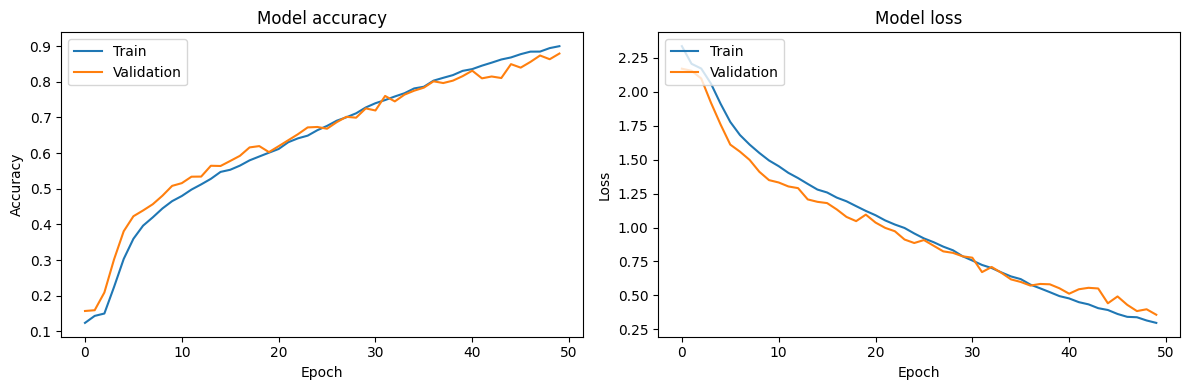

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Generate confusion matrix
test_generator.reset()
test_steps = math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps)

103/103 [==============================] - 7s 55ms/step


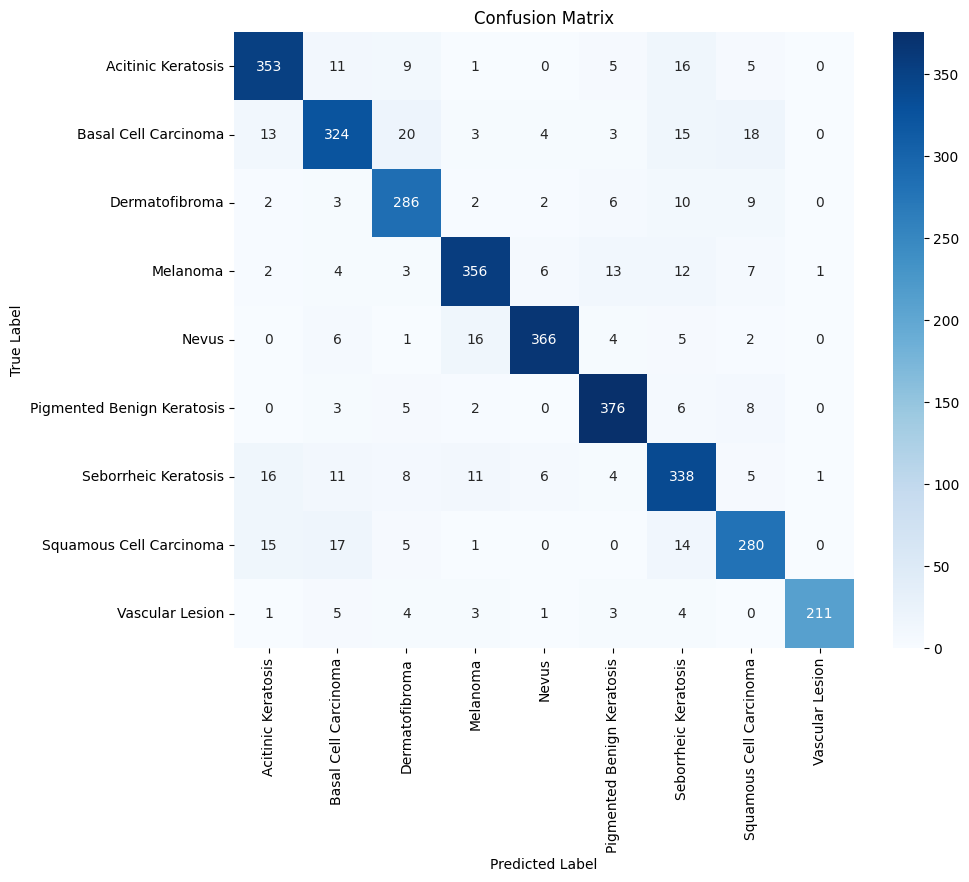

In [ ]:
# Convert predictions to class labels
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Create and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, 
                          target_names=test_generator.class_indices.keys()))


Classification Report:
                            precision    recall  f1-score   support

        Acitinic Keratosis       0.88      0.88      0.88       400
      Basal Cell Carcinoma       0.84      0.81      0.83       400
            Dermatofibroma       0.84      0.89      0.87       320
                  Melanoma       0.90      0.88      0.89       404
                     Nevus       0.95      0.92      0.93       400
Pigmented Benign Keratosis       0.91      0.94      0.92       400
      Seborrheic Keratosis       0.80      0.84      0.82       400
   Squamous Cell Carcinoma       0.84      0.84      0.84       332
           Vascular Lesion       0.99      0.91      0.95       232

                  accuracy                           0.88      3288
                 macro avg       0.88      0.88      0.88      3288
              weighted avg       0.88      0.88      0.88      3288



In [ ]:
history = model.fit(train_generator,epochs=10,validation_data=val_generator)

Epoch 1/10
822/822 [==============================] - 106s 129ms/step - loss: 0.2933 - accuracy: 0.9025 - val_loss: 0.3642 - val_accuracy: 0.8779
Epoch 2/10
822/822 [==============================] - 106s 129ms/step - loss: 0.2728 - accuracy: 0.9094 - val_loss: 0.3847 - val_accuracy: 0.8764
Epoch 3/10
822/822 [==============================] - 107s 130ms/step - loss: 0.2614 - accuracy: 0.9141 - val_loss: 0.4268 - val_accuracy: 0.8612
Epoch 4/10
822/822 [==============================] - 107s 130ms/step - loss: 0.2523 - accuracy: 0.9145 - val_loss: 0.3515 - val_accuracy: 0.8843
Epoch 5/10
822/822 [==============================] - 108s 132ms/step - loss: 0.2410 - accuracy: 0.9199 - val_loss: 0.3558 - val_accuracy: 0.8880
Epoch 6/10
822/822 [==============================] - 109s 133ms/step - loss: 0.2212 - accuracy: 0.9281 - val_loss: 0.3518 - val_accuracy: 0.8916
Epoch 7/10
822/822 [==============================] - 108s 131ms/step - loss: 0.2198 - accuracy: 0.9247 - val_loss: 0.3609 -